# LPM-модель: подгонка, интерпретация коэффициентов, t-тест

In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.iolib.summary2 import summary_col, summary_params
from scipy.stats import t # t-распределение
from scipy.stats import norm # нормальное распределение
import matplotlib.pyplot as plt
import seaborn as sns

# 1 Подгонка модели

## 1.1 approve equation #1

Для датасета `loanapp` рассморим регрессию **approve на mortno, unem, dep, male, married, yjob, self**

Спецификация: 
$$
  approve=\beta_0+\beta_1mortno+\beta_2unem+\beta_3dep+\beta_4male+\beta_5married+\beta_6yjob+\beta_7self+u
$$

Альтернативная спецификация:
$$
  P(approve=1)=\beta_0+\beta_1mortno+\beta_2unem+\beta_3dep+\beta_4male+\beta_5married+\beta_6yjob+\beta_7self
$$

In [3]:
# подключим датасет loanapp по ссылке 
loanapp_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/econometrica/main/econometrica2/data-csv/loanapp.csv', na_values=(' ', '', '  '))
#подключим датасет loanapp из локального файла
#loanapp_df = pd.read_csv('loanapp.csv', na_values=(' ', '', '  '))

Датасет `loanapp`

Основные переменные
	
- `approve` - бинарная, 1 если кредитная заявка одобрена 
- `appinc` - доход заявителя  (в \$1000)
- `mortno` -  бинарная, 1 если нет ипотечной кредитной истории 
- `unem` - уровень безработицы в отрасли в \% 
- `dep` - количество иждивенцев 
- `male` - гендерный фактор 
- `married` - семейный статус 
- `yjob` - стаж на текущей работе 
- `self` - бинарная, 1 если самозанятый 
	

In [4]:
# посмотрим на первые пять строк датасета loanapp
loanapp_df.head(n=5)

,occ,loanamt,action,msa,suffolk,appinc,typur,unit,married,dep,...,approve,mortno,mortperf,mortlat1,mortlat2,chist,multi,loanprc,thick,white
0,1,89,1,1120,0,72,0,1.0,0.0,0.0,...,1,0,1,0,0,1,0.0,0.754237,0.0,1
1,1,128,3,1120,0,74,0,1.0,1.0,1.0,...,0,0,1,0,0,1,0.0,0.800000,1.0,1
2,1,128,1,1120,0,84,3,1.0,0.0,0.0,...,1,0,1,0,0,1,0.0,0.895105,1.0,1
3,1,66,1,1120,0,36,0,1.0,1.0,0.0,...,1,0,1,0,0,0,0.0,0.600000,0.0,1
4,1,120,1,1120,0,59,8,1.0,1.0,0.0,...,1,0,1,0,0,1,0.0,0.895522,0.0,1


In [5]:
# размеры датасета loanapp
loanapp_df.shape

(1989, 59)

In [6]:
# информация о датасете loanapp
loanapp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   occ       1989 non-null   int64  
 1   loanamt   1989 non-null   int64  
 2   action    1989 non-null   int64  
 3   msa       1989 non-null   int64  
 4   suffolk   1989 non-null   int64  
 5   appinc    1989 non-null   int64  
 6   typur     1989 non-null   int64  
 7   unit      1985 non-null   float64
 8   married   1986 non-null   float64
 9   dep       1986 non-null   float64
 10  emp       1989 non-null   int64  
 11  yjob      1989 non-null   int64  
 12  self      1989 non-null   int64  
 13  atotinc   1989 non-null   int64  
 14  cototinc  1989 non-null   float64
 15  hexp      1989 non-null   float64
 16  price     1989 non-null   float64
 17  other     1989 non-null   float64
 18  liq       1989 non-null   float64
 19  rep       1980 non-null   float64
 20  gdlin     1989 non-null   int6

In [7]:
# найдем пропуски в датафрейме и просуммируем их по столбцам (число пропусков по каждой переменной)
loanapp_df.isna().sum()

occ           0
loanamt       0
action        0
msa           0
suffolk       0
appinc        0
typur         0
unit          4
married       3
dep           3
emp           0
yjob          0
self          0
atotinc       0
cototinc      0
hexp          0
price         0
other         0
liq           0
rep           9
gdlin         0
lines         0
mortg         0
cons          0
pubrec        0
hrat          0
obrat         0
fixadj        0
term          0
apr           0
prop          0
inss          0
inson         0
gift          0
cosign        0
unver         0
review        0
netw          0
unem          0
min30       183
bd            0
mi            0
old           0
vr            0
sch           0
black         0
hispan        0
male         15
reject        0
approve       0
mortno        0
mortperf      0
mortlat1      0
mortlat2      0
chist         0
multi         4
loanprc       0
thick         9
white         0
dtype: int64

### 1 способ: зададим спецификацию модели через матрицы ргерессионного дизайна 

[Документация по удалению строк со значением NaN](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

In [8]:
# удалить все строки DataFrame, которые имеют значение NaN в столбцах mortno, unem, dep, male, married, yjob, self
loanapp_df = loanapp_df.dropna(subset=['mortno','unem','dep', 'male', 'married', 'yjob', 'self'])
#сбросим индекс DataFrame после удаления строк со значениями NaN
loanapp_df = loanapp_df.reset_index(drop=True)
loanapp_df

,occ,loanamt,action,msa,suffolk,appinc,typur,unit,married,dep,...,approve,mortno,mortperf,mortlat1,mortlat2,chist,multi,loanprc,thick,white
0,1,128,3,1120,0,74,0,1.0,1.0,1.0,...,0,0,1,0,0,1,0.0,0.800000,1.0,1
1,1,128,1,1120,0,84,3,1.0,0.0,0.0,...,1,0,1,0,0,1,0.0,0.895105,1.0,1
2,1,66,1,1120,0,36,0,1.0,1.0,0.0,...,1,0,1,0,0,0,0.0,0.600000,0.0,1
3,1,120,1,1120,0,59,8,1.0,1.0,0.0,...,1,0,1,0,0,1,0.0,0.895522,0.0,1
4,1,111,1,1120,0,63,9,1.0,0.0,0.0,...,1,0,1,0,0,0,0.0,0.804348,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,1,158,1,1120,0,96,0,1.0,1.0,0.0,...,1,0,1,0,0,1,0.0,0.897727,0.0,1
1967,1,35,1,1120,0,169,1,1.0,1.0,0.0,...,1,1,0,0,0,1,0.0,0.111111,0.0,1
1968,2,225,1,1120,0,49,0,2.0,1.0,0.0,...,1,0,1,0,0,1,1.0,1.000000,0.0,1
1969,1,98,1,1120,1,110,1,1.0,0.0,0.0,...,1,1,0,0,0,1,0.0,0.455814,0.0,1


In [9]:
# Зададим матрицы регрессионного дизайна
y = loanapp_df['approve'] # зависимая переменная
X = add_constant(loanapp_df[['mortno','unem','dep', 'male', 'married', 'yjob', 'self']]) # регрессоры с добавленным столбом единиц
X.head(n=7)

,const,mortno,unem,dep,male,married,yjob,self
0,1.0,0,3.2,1.0,1.0,1.0,0,0
1,1.0,0,3.9,0.0,1.0,0.0,1,0
2,1.0,0,3.1,0.0,1.0,1.0,0,1
3,1.0,0,4.3,0.0,1.0,1.0,0,0
4,1.0,0,3.2,0.0,1.0,0.0,0,0
5,1.0,0,3.2,0.0,1.0,0.0,1,0
6,1.0,0,3.2,0.0,1.0,0.0,1,0


In [10]:
mod_lpm = sm.OLS(endog=y, exog=X)
res_lpm_hc = mod_lpm.fit(cov_type='HC3')
print(res_lpm_hc.summary(slim=True))
# поскольку регрессоры dep, male и married содержат пропуски (ячейки заполнины NaN), то получим сообщение об ошибке: 'exog contains inf or nans'. 
# необходимо эти пропуски удалить в ручную или автоматичеки (во втором способе)

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                1971   F-statistic:                     5.849
Covariance Type:                  HC3   Prob (F-statistic):           9.77e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8642      0.023     37.135      0.000       0.819       0.910
mortno         0.0733      0.015      4.886      0.000       0.044       0.103
unem          -0.0064      0.004     -1.605      0.108      -0.014       0.001
dep           -0.0185      0.008     -2.429      0.015      -0.033      -0.004
male           0.0019      0.021      0.089      0.929      -0.040       0.044
married        0.0459      0.019      2.458      0.0

### 2 способ: зададим спецификацию модели через формулу

In [11]:
#зададим спецификацию модели через формулу
mod_lpm = smf.ols(formula='approve~mortno+unem+dep+male+married+yjob+self', data=loanapp_df)
# подгонка модели
res_lpm_hc = mod_lpm.fit(cov_type='HC3')
print(res_lpm_hc.summary(slim=True))
# Альтеративно
# res_lpm_hc = sm.OLS.from_formula(formula='approve~mortno+unem+dep+male+married+yjob+self', data=loanapp_df)

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                1971   F-statistic:                     5.849
Covariance Type:                  HC3   Prob (F-statistic):           9.77e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8642      0.023     37.135      0.000       0.819       0.910
mortno         0.0733      0.015      4.886      0.000       0.044       0.103
unem          -0.0064      0.004     -1.605      0.108      -0.014       0.001
dep           -0.0185      0.008     -2.429      0.015      -0.033      -0.004
male           0.0019      0.021      0.089      0.929      -0.040       0.044
married        0.0459      0.019      2.458      0.0

In [12]:
# Коэфициенты модели с округлением до 3-х десятичных знаков
res_lpm_hc.params.round(3)

Intercept    0.864
mortno       0.073
unem        -0.006
dep         -0.018
male         0.002
married      0.046
yjob        -0.001
self        -0.036
dtype: float64

In [13]:
res_lpm_ols = mod_lpm.fit(cov_type='nonrobust')
# Сравнение моделей
print(summary_col([res_lpm_hc, res_lpm_ols], model_names=['Robust', 'Non-robust'], stars=True))  


                 Robust  Non-robust
-----------------------------------
Intercept      0.8642*** 0.8642*** 
               (0.0233)  (0.0219)  
mortno         0.0733*** 0.0733*** 
               (0.0150)  (0.0160)  
unem           -0.0064   -0.0064*  
               (0.0040)  (0.0035)  
dep            -0.0185** -0.0185** 
               (0.0076)  (0.0072)  
male           0.0019    0.0019    
               (0.0214)  (0.0203)  
married        0.0459**  0.0459*** 
               (0.0187)  (0.0176)  
yjob           -0.0007   -0.0007   
               (0.0062)  (0.0067)  
self           -0.0361   -0.0361   
               (0.0247)  (0.0223)  
R-squared      0.0203    0.0203    
R-squared Adj. 0.0168    0.0168    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [14]:
# Коэфициенты модели с округлением до 3-х десятичных знаков
res_lpm_ols.params.round(3)

Intercept    0.864
mortno       0.073
unem        -0.006
dep         -0.018
male         0.002
married      0.046
yjob        -0.001
self        -0.036
dtype: float64

## Интерпретация коэффициентов модели

для регрессора `mortno`: разница **вероятностей** между уровнями 0 и 1 равна `0.073`

при увеличении регрессора `unem` на единицу **вероятность** `успеха` уменьшится на `0.006`

при увеличении регрессора `dep` на единицу **вероятность** `успеха` уменьшится на `0.018`

для регрессора `male`: разница **вероятностей** между уровнями 0 и 1 равна `0.002`

для регрессора `married`: разница **вероятностей** между уровнями 0 и 1 равна `0.046`

при увеличении регрессора `yjob` на единицу **вероятность** `успеха` уменьшится на `0.001`

для регрессора `self`: разница **вероятностей** между уровнями 0 и 1 равна `0.036`

# 2 t-тест

## Значимость коэффициентов
Тестируем гипотезу $H_0:\beta=0$

Тестовая статистика $$t=\frac{\hat{\beta}}{s.e.(\beta)}$$

Критическое $t_{cr}=t_{df=n-k-1}(\alpha)$

### 2.1 approve equation #1

Для датасета `loanapp` рассморим регрессию **approve на mortno, unem, dep, male, married, yjob, self**

Спецификация модели и подгонка выполнены в задаче 1.1

In [15]:
# робастные t-статистики для каждого коэффициента с округлением до 3-х десятичных знаков
np.round(res_lpm_hc.tvalues, 3)

Intercept    37.135
mortno        4.886
unem         -1.605
dep          -2.429
male          0.089
married       2.458
yjob         -0.107
self         -1.464
dtype: float64

In [16]:
# Число наблюдений в модели, число регрессоров и степени свободы для t_cr
res_lpm_hc.nobs, res_lpm_hc.df_model, res_lpm_hc.df_resid

(1971.0, 7.0, 1963.0)

Тестируем гипотезу на уровне значимости 1\% (т.е. $\alpha = 0.01$)

In [17]:
# 1%-критическое значение t-распределения
np.round(t.ppf(q=1-0.01/2, df=res_lpm_hc.df_resid), 3)

2.578

In [18]:
# Результаты t-теста для коэффициентов (неробастные s.e.)
summary_params(res_lpm_ols, alpha=0.01)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995]
Intercept,0.864212,0.021910,39.444211,4.383373e-251,0.807721,0.920702
mortno,0.073251,0.016000,4.578293,4.981615e-06,0.031999,0.114503
unem,-0.006434,0.003463,-1.857970,6.332293e-02,-0.015363,0.002495
dep,-0.018472,0.007187,-2.570198,1.023721e-02,-0.037003,0.000058
male,0.001907,0.020314,0.093879,9.252152e-01,-0.050469,0.054283
married,0.045946,0.017644,2.604031,9.282926e-03,0.000453,0.091439
yjob,-0.000662,0.006686,-0.099092,9.210751e-01,-0.017900,0.016575
self,-0.036120,0.022289,-1.620504,1.052847e-01,-0.093589,0.021349


In [19]:
# проверим значимость коэффициентов 
df_ols = np.round(summary_params(res_lpm_ols, alpha=0.01), 3)
df_ols['significance'] = df_ols.apply(lambda x: 'Значим' if x['P>|t|']<0.01 else 'Незначим', axis=1)
df_ols

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.022,39.444,0.000,0.808,0.921,Значим
mortno,0.073,0.016,4.578,0.000,0.032,0.115,Значим
unem,-0.006,0.003,-1.858,0.063,-0.015,0.002,Незначим
dep,-0.018,0.007,-2.570,0.010,-0.037,0.000,Незначим
male,0.002,0.020,0.094,0.925,-0.050,0.054,Незначим
married,0.046,0.018,2.604,0.009,0.000,0.091,Значим
yjob,-0.001,0.007,-0.099,0.921,-0.018,0.017,Незначим
self,-0.036,0.022,-1.621,0.105,-0.094,0.021,Незначим


**ВЫВОД**: На уровне значимости 1% значимы коэффициенты: `mortno` и `married`

In [20]:
# Результаты t-теста для коэффициентов (робастные s.e.)
summary_params(res_lpm_hc, alpha=0.01)

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995]
Intercept,0.864212,0.023272,37.134809,7.710753e-302,0.804266,0.924157
mortno,0.073251,0.014993,4.885535,1.031484e-06,0.034630,0.111872
unem,-0.006434,0.004008,-1.605254,1.084379e-01,-0.016758,0.003890
dep,-0.018472,0.007605,-2.429081,1.513714e-02,-0.038061,0.001116
male,0.001907,0.021351,0.089319,9.288281e-01,-0.053089,0.056903
married,0.045946,0.018692,2.458098,1.396750e-02,-0.002201,0.094093
yjob,-0.000662,0.006189,-0.107050,9.147495e-01,-0.016603,0.015278
self,-0.036120,0.024671,-1.464087,1.431703e-01,-0.099667,0.027427


In [21]:
# проверим значимость коэффициентов 
df_hc = np.round(summary_params(res_lpm_hc, alpha=0.01), 3)
df_hc['significance'] = df_hc.apply(lambda x: 'Значим' if x['P>|t|']<0.01 else 'Незначим', axis=1)
df_hc

,Coef.,Std.Err.,t,P>|t|,[0.005,0.995],significance
Intercept,0.864,0.023,37.135,0.000,0.804,0.924,Значим
mortno,0.073,0.015,4.886,0.000,0.035,0.112,Значим
unem,-0.006,0.004,-1.605,0.108,-0.017,0.004,Незначим
dep,-0.018,0.008,-2.429,0.015,-0.038,0.001,Незначим
male,0.002,0.021,0.089,0.929,-0.053,0.057,Незначим
married,0.046,0.019,2.458,0.014,-0.002,0.094,Незначим
yjob,-0.001,0.006,-0.107,0.915,-0.017,0.015,Незначим
self,-0.036,0.025,-1.464,0.143,-0.100,0.027,Незначим


**ВЫВОД**: На уровне значимости 1% значим коэффициент `mortno`

### Значимость выбранных коэффициентов
Потестируем значимость $\beta_{1}$ и $\beta_{4}$

In [22]:
res_lpm_hc.t_test('mortno=0, male=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0733      0.015      4.886      0.000       0.044       0.103
c1             0.0019      0.021      0.089      0.929      -0.040       0.044

## 1.4 labour force equation #2

Для датасета [mroz_Greene](http://www.stern.nyu.edu/~wgreene/Text/Edition7/TableF5-1.csv)
рассморим регрессию **LFP на WA, WE, CIT, UN, log(FAMINC)**

In [4]:
# подключим датасет [mroz_Greene](http://www.stern.nyu.edu/~wgreene/Text/Edition7/TableF5-1.csv) по ссылке 
mroz_Greene = pd.read_csv('https://raw.githubusercontent.com/artamonoff/econometrica/main/econometrica2/data-csv/TableF5-1.csv', na_values=(' ', '', '  '))
#подключим датасет mroz_Greene из локального файла
#mroz_Greene = pd.read_csv('TableF5-1.csv', na_values=(' ', '', '  '))

In [3]:
#зададим спецификацию модели через формулу
mod4_lpm = smf.ols(formula='LFP~WA+WE+CIT+UN+np.log(FAMINC)', data=mroz_Greene)
# подгонка модели
res4_lpm_hc = mod4_lpm.fit(cov_type='HC3')
print(res4_lpm_hc.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                    LFP   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.042
No. Observations:                 753   F-statistic:                     8.172
Covariance Type:                  HC3   Prob (F-statistic):           1.59e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5359      0.368     -1.457      0.145      -1.257       0.185
WA                -0.0037      0.002     -1.635      0.102      -0.008       0.001
WE                 0.0333      0.008      4.036      0.000       0.017       0.049
CIT               -0.0478      0.039     -1.212      0.226      -0.125       0.029
UN                -0.0050      0.006     -0.855      0.392      -0.017       0.006
np.log(FAMINC)     0.093

## Замечание: почему log(FAMINC)

Нарисуем гистограмму FAMINC с наложенной кривой нормального распределения

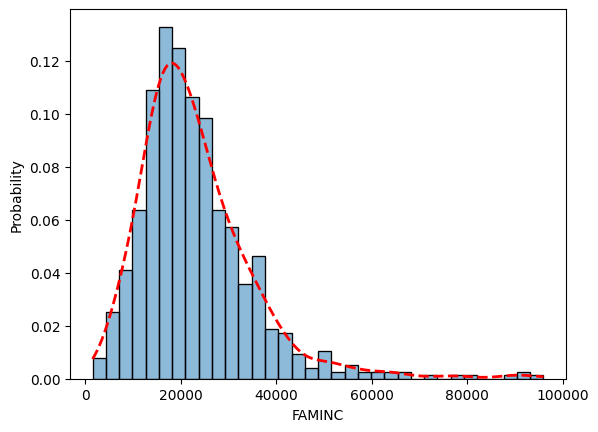

In [75]:
sns.histplot(data=mroz_Greene, x='FAMINC', stat='probability', kde=True, line_kws = {'linestyle':'dashed',
                         'linewidth':'2'}).lines[0].set_color('red')

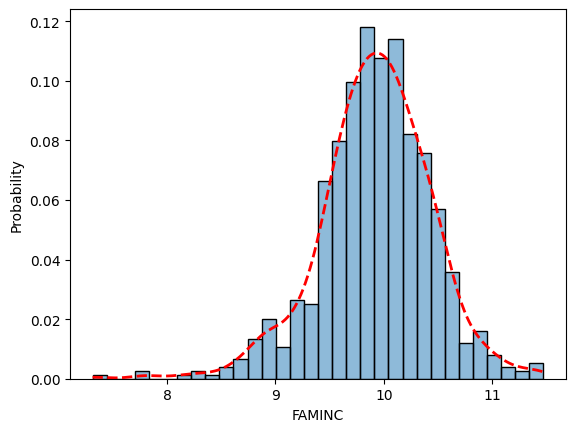

In [66]:
sns.histplot(data=mroz_Greene, x=np.log(mroz_Greene['FAMINC']), stat='probability', kde=True, line_kws = {'linestyle':'dashed',
                         'linewidth':'2'}).lines[0].set_color('red')

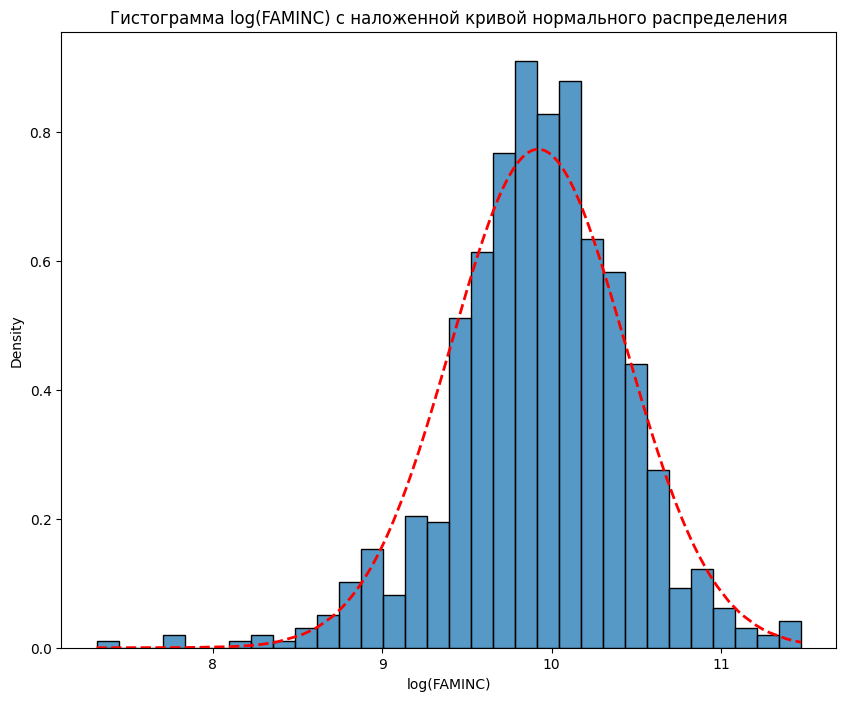

In [92]:
# Создание данных для гистограммы
log_FAMINC = np.log(mroz_Greene['FAMINC'])
# Создание данных для графика функции
x_mean = np.mean(log_FAMINC)
x_std = np.std(log_FAMINC)
y_function = norm.pdf(log_FAMINC, x_mean, x_std)
# Построение кривой нормального распределения и гистограммы на одной плоскости
plt.figure(figsize=(10, 8))
sns.lineplot(x=log_FAMINC, y=y_function, color='red', linestyle='dashed', linewidth='2')
sns.histplot(log_FAMINC, stat='density') 

plt.xlabel('log(FAMINC)')
plt.ylabel('Density')
plt.title('Гистограмма log(FAMINC) с наложенной кривой нормального распределения')
plt.show()

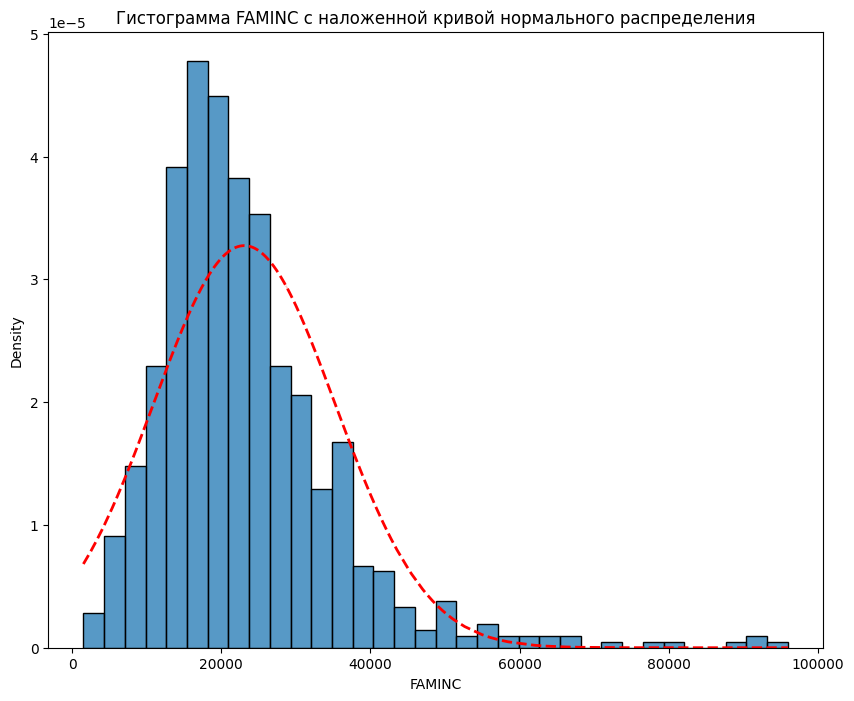

In [93]:
# Создание данных для гистограммы
FAMINC = mroz_Greene['FAMINC']
# Создание данных для графика функции
x_mean = np.mean(FAMINC)
x_std = np.std(FAMINC)
y_function = norm.pdf(FAMINC, x_mean, x_std)
# Построение кривой нормального распределения и гистограммы на одной плоскости
plt.figure(figsize=(10, 8))
sns.lineplot(x=FAMINC, y=y_function, color='red', linestyle='dashed', linewidth='2')
sns.histplot(FAMINC, stat='density') 
plt.xlabel('FAMINC')
plt.ylabel('Density')
plt.title('Гистограмма FAMINC с наложенной кривой нормального распределения')
plt.show()